### Задача выбора кредита в Tinkoff
Исходная выборка содержит записи о 170 746 клиентах, классифицированных на два класса: `0 – клиент не открыл кредитный счет в банке (140 690 клиентов)` и `1 – клиент открыл кредитный счет в банке (30 056 клиентов)`.
Необходимо классифицировать клиентов на тех, кто не откроет кредитного счета, и тех, кто его откроет. По каждому наблюдению (клиенту) фиксируются 15 исходных переменных.

#### Список исходных переменных включает в себя:
* категориальный предиктор Идентификационный номер `[client_id]`
* категориальный предиктор Пол `[gender]`
* количественный предиктор Возраст `[age]`
* категориальный предиктор Семейный статус `[marital_status]`
* категориальный предиктор Сфера занятости `[job_position]`
* количественный предиктор Сумма кредита `[credit_sum]`
* количественный предиктор Срок кредитования `[credit_month]`
* количественный предиктор Внутренняя скоринговая оценка `[score_shk]`
* категориальный предиктор Образование `[education]`
* категориальный предиктор Идентификационный номер тарифа `[tariff_id]`
* количественный предиктор Месячный заработок `[monthly_income]`
* количественный предиктор Количество кредитов у клиента `[credit_count]`
* количественный предиктор Количество просроченных кредитов у клиента `[overdue_credit_count]`
* категориальная зависимая переменная Факт открытия кредитного счета в данном банке `[open_account_flg]`

In [2]:
# Делаем импорт необходимых модулей
import numpy as np
import pandas as pd
import re   # модуль регулярок
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')
from sklearn.metrics import roc_auc_score, accuracy_score # Функция для рассчета AUROC
from sklearn.metrics import roc_curve # Функция для построения ROC-кривой
from sklearn.metrics import confusion_matrix  # функция расчета матрицы ошибок
from sklearn.metrics import classification_report # функция для расчета метрик качества классификации
from sklearn.metrics import plot_confusion_matrix # функция для визуализации матрицы ошибок

In [3]:
# Выодим файл с данными
df = pd.read_csv('credit_train.csv', sep = ';', encoding='cp1251')
df.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,48,MAR,UMN,"59998,00",10,1.6,"0,770249",GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,28,MAR,UMN,"10889,00",6,1.1,"0,248514",GRD,МОСКВА,43000.0,2.0,0.0,0
2,3,M,32,MAR,SPC,"10728,00",12,1.1,"0,459589",SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0
3,4,F,27,DIV,SPC,"12009,09",12,1.1,"0,362536",GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
4,5,M,45,MAR,SPC,"16908,89",10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0


In [4]:
# смотрим форму датафрейма
df.shape

(170746, 15)

In [9]:
# Удалим идентификационную переменную client_id.
df.drop('client_id', axis=1, inplace=True)
df

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,48,MAR,UMN,"59998,00",10,1.60,"0,770249",GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,F,28,MAR,UMN,"10889,00",6,1.10,"0,248514",GRD,МОСКВА,43000.0,2.0,0.0,0
2,M,32,MAR,SPC,"10728,00",12,1.10,"0,459589",SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0
3,F,27,DIV,SPC,"12009,09",12,1.10,"0,362536",GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
4,M,45,MAR,SPC,"16908,89",10,1.10,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,F,27,UNM,SPC,"64867,00",12,1.10,"0,535257",GRD,РЕСПУБЛИКА ТАТАРСТАН,40000.0,6.0,0.0,0
170742,F,24,MAR,SPC,"17640,00",6,1.60,"0,573287",SCH,САНКТ-ПЕТЕРБУРГ Г,30000.0,1.0,0.0,0
170743,F,31,UNM,SPC,"27556,47",10,1.32,"0,416098",GRD,ПРИМОРСКИЙ КРАЙ,40000.0,1.0,0.0,0
170744,F,53,DIV,PNA,"6189,00",12,1.10,"0,482595",SCH,ПЕНЗЕНСКАЯ ОБЛ,31000.0,2.0,0.0,0


#### Преобразование `[living_region]` к одному виду

In [5]:
# смотрим уникальные значения по переменной living_region
df['living_region'].unique()

array(['КРАСНОДАРСКИЙ КРАЙ', 'МОСКВА', 'ОБЛ САРАТОВСКАЯ',
       'ОБЛ ВОЛГОГРАДСКАЯ', 'ЧЕЛЯБИНСКАЯ ОБЛАСТЬ', 'СТАВРОПОЛЬСКИЙ КРАЙ',
       'ОБЛ НИЖЕГОРОДСКАЯ', 'МОСКОВСКАЯ ОБЛ',
       'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА', 'КРАЙ СТАВРОПОЛЬСКИЙ',
       'САНКТ-ПЕТЕРБУРГ', 'РЕСП. БАШКОРТОСТАН', 'ОБЛ АРХАНГЕЛЬСКАЯ',
       'ХАНТЫ-МАНСИЙСКИЙ АО', 'РЕСП БАШКОРТОСТАН', 'ПЕРМСКИЙ КРАЙ',
       'РЕСП КАРАЧАЕВО-ЧЕРКЕССКАЯ', 'САРАТОВСКАЯ ОБЛ', 'ОБЛ КАЛУЖСКАЯ',
       'ОБЛ ВОЛОГОДСКАЯ', 'РОСТОВСКАЯ ОБЛ', 'УДМУРТСКАЯ РЕСП',
       'ОБЛ ИРКУТСКАЯ', 'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'ОБЛ МОСКОВСКАЯ',
       'ОБЛ ТЮМЕНСКАЯ', 'ОБЛ БЕЛГОРОДСКАЯ', 'РОСТОВСКАЯ ОБЛАСТЬ',
       'ОБЛ КОСТРОМСКАЯ', 'РЕСП ХАКАСИЯ', 'РЕСПУБЛИКА ТАТАРСТАН',
       'ИРКУТСКАЯ ОБЛАСТЬ', 'ОБЛ СВЕРДЛОВСКАЯ', 'ОБЛ ПСКОВСКАЯ',
       'КРАЙ ЗАБАЙКАЛЬСКИЙ', 'СВЕРДЛОВСКАЯ ОБЛ', 'ОБЛ ОРЕНБУРГСКАЯ',
       'ОБЛ ВОРОНЕЖСКАЯ', 'ОБЛ АСТРАХАНСКАЯ', 'ОБЛ НОВОСИБИРСКАЯ',
       'ОБЛ ЧЕЛЯБИНСКАЯ', 'ОРЕНБУРГСКАЯ ОБЛ', 'СВЕРДЛОВСКАЯ ОБЛАСТЬ'

#### Видим что многие одинаковые переменные переменные по региону пишутся по разному
###### Например ` Томская обл и Томская`

In [6]:
# Уникальные значения переменной living_region записывем в отдельный объект regions
regions = df['living_region'].unique()
# создаем серию, у которой в качестве значений и индексных меток будут выступать
# уникальные значенияпеременной living_region
regions = pd.Series(data=regions, index=regions, name='regions')
regions

КРАСНОДАРСКИЙ КРАЙ                КРАСНОДАРСКИЙ КРАЙ
МОСКВА                                        МОСКВА
ОБЛ САРАТОВСКАЯ                      ОБЛ САРАТОВСКАЯ
ОБЛ ВОЛГОГРАДСКАЯ                  ОБЛ ВОЛГОГРАДСКАЯ
ЧЕЛЯБИНСКАЯ ОБЛАСТЬ              ЧЕЛЯБИНСКАЯ ОБЛАСТЬ
                                      ...           
РЕСП.БАШКОРТОСТАН                  РЕСП.БАШКОРТОСТАН
КРАЙ. ПЕРМСКИЙ                        КРАЙ. ПЕРМСКИЙ
РЕСП ЧУВАШСКАЯ - ЧУВАШИЯ    РЕСП ЧУВАШСКАЯ - ЧУВАШИЯ
ОБЛ. КИРОВСКАЯ                        ОБЛ. КИРОВСКАЯ
КАЛИНИНГРАДСКАЯ ОБЛ.            КАЛИНИНГРАДСКАЯ ОБЛ.
Name: regions, Length: 302, dtype: object

In [8]:
# Чистка серии regions

# Создаем список со стоп словами
stop_words = set(['ОБЛ', 'ОБЛАСТЬ', 'РЕСП', 'РЕСПУБЛИКА', 'КРАЙ', 
                  'Г', 'АО', 'АОБЛ', 'АВТОНОМНАЯ'])

# Напишем функцию для предобработки значений в regions

def clean_regions(x):
    x = re.sub('[.,]+', ' ', str(x)) # чистим от .,
    words = x.split(' ') # создаем после чистки список слов, разделенных проблелом
    words_new = []
    for w in words:      # пробегаем циклом по словам
        if not w in stop_words:   # Если слова нету в списке стопслов
            words_new.append(w)  #
    x = ''.join(words_new)
    return x
# Применяем функцию к нашей серии

regions = regions.map(clean_regions) # map() используется для примения функции к каждому
                                    # к кадому имтерируемому объекту

       

In [9]:
pd.options.display.max_rows = 310
regions

КРАСНОДАРСКИЙ КРАЙ                                                 КРАСНОДАРСКИЙ
МОСКВА                                                                    МОСКВА
ОБЛ САРАТОВСКАЯ                                                      САРАТОВСКАЯ
ОБЛ ВОЛГОГРАДСКАЯ                                                  ВОЛГОГРАДСКАЯ
ЧЕЛЯБИНСКАЯ ОБЛАСТЬ                                                  ЧЕЛЯБИНСКАЯ
СТАВРОПОЛЬСКИЙ КРАЙ                                               СТАВРОПОЛЬСКИЙ
ОБЛ НИЖЕГОРОДСКАЯ                                                  НИЖЕГОРОДСКАЯ
МОСКОВСКАЯ ОБЛ                                                        МОСКОВСКАЯ
ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА    ХАНТЫ-МАНСИЙСКИЙАВТОНОМНЫЙОКРУГ-ЮГРА
КРАЙ СТАВРОПОЛЬСКИЙ                                               СТАВРОПОЛЬСКИЙ
САНКТ-ПЕТЕРБУРГ                                                  САНКТ-ПЕТЕРБУРГ
РЕСП. БАШКОРТОСТАН                                                  БАШКОРТОСТАН
ОБЛ АРХАНГЕЛЬСКАЯ           

In [10]:
# Внесем финальные корректировки
regions['ЧУКОТСКИЙ АO'] = 'ЧУКОТСКИЙ'
regions['ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions['ЧУВАШИЯ ЧУВАШСКАЯ РЕСПУБЛИКА -'] = 'ЧУВАШСКАЯ'
regions['ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП'] = 'ЧУВАШСКАЯ'
regions['РЕСП ЧУВАШСКАЯ - ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions['ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП'] = 'ЧУВАШСКАЯ'
regions['РЕСПУБЛИКАТАТАРСТАН'] = 'ТАТАРСТАН'
regions['ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ'] = 'МОСКОВСКАЯ'
regions['ПЕРМСКАЯ ОБЛ'] = 'ПЕРМСКИЙ'
regions['ОРЁЛ'] = 'ОРЛОВСКАЯ'
regions['Г.ОДИНЦОВО МОСКОВСКАЯ ОБЛ'] = 'МОСКОВСКАЯ'
regions['МЫТИЩИНСКИЙ Р-Н'] = 'МОСКОВСКАЯ'
regions['МОСКОВСКИЙ П'] = 'МОСКОВСКАЯ'
regions['КАМЧАТСКАЯ ОБЛАСТЬ'] = 'КАМЧАТСКИЙ'
regions['ДАЛЬНИЙ ВОСТОК'] = 'ДАЛЬНИЙ ВОСТОК'
regions['ДАЛЬНИЙВОСТОК'] = 'МОСКОВСКАЯ'
regions['ГУСЬ-ХРУСТАЛЬНЫЙ Р-Н'] = 'ВЛАДИМИРСКАЯ'
regions['ГОРЬКОВСКАЯ ОБЛ'] = 'НИЖЕГОРОДСКАЯ'
regions['ЭВЕНКИЙСКИЙ АО'] = 'КРАСНОЯРСКИЙ'
regions['ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions['АО ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - Ю'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions['АО ХАНТЫ-МАНСИЙСКИЙ-ЮГРА'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions['СЕВ. ОСЕТИЯ - АЛАНИЯ'] = 'СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ'
regions['РЕСП. САХА (ЯКУТИЯ)'] = 'САХА/ЯКУТИЯ/'
regions['РЕСПУБЛИКА САХА'] = 'САХА/ЯКУТИЯ/'
regions['ДАЛЬНИЙВОСТОК'] = 'МОСКОВСКАЯ'
regions['САХА'] = 'САХА/ЯКУТИЯ/'
regions['98'] = 'САНКТ-ПЕТЕРБУРГ'
regions['74'] = 'ЧЕЛЯБИНСКАЯ'
regions['РОССИЯ'] = 'МОСКОВСКАЯ'
regions['МОСКВОСКАЯ'] = 'МОСКОВСКАЯ'
regions['МОСКВОСКАЯ ОБЛ'] = 'МОСКОВСКАЯ'
regions['ЧЕЛЯБИНСК'] = 'ЧЕЛЯБИНСКАЯ'
regions['Г. ЧЕЛЯБИНСК'] = 'ЧЕЛЯБИНСКАЯ'
regions['БРЯНСКИЙ'] = 'БРЯНСКАЯ'


In [21]:
regions

КРАСНОДАРСКИЙ КРАЙ                                  КРАСНОДАРСКИЙ
МОСКВА                                                     МОСКВА
ОБЛ САРАТОВСКАЯ                                       САРАТОВСКАЯ
ОБЛ ВОЛГОГРАДСКАЯ                                   ВОЛГОГРАДСКАЯ
ЧЕЛЯБИНСКАЯ ОБЛАСТЬ                                   ЧЕЛЯБИНСКАЯ
СТАВРОПОЛЬСКИЙ КРАЙ                                СТАВРОПОЛЬСКИЙ
ОБЛ НИЖЕГОРОДСКАЯ                                   НИЖЕГОРОДСКАЯ
МОСКОВСКАЯ ОБЛ                                         МОСКОВСКАЯ
ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА         ХАНТЫ-МАНСИЙСКИЙ
КРАЙ СТАВРОПОЛЬСКИЙ                                СТАВРОПОЛЬСКИЙ
САНКТ-ПЕТЕРБУРГ                                   САНКТ-ПЕТЕРБУРГ
РЕСП. БАШКОРТОСТАН                                   БАШКОРТОСТАН
ОБЛ АРХАНГЕЛЬСКАЯ                                   АРХАНГЕЛЬСКАЯ
ХАНТЫ-МАНСИЙСКИЙ АО                              ХАНТЫ-МАНСИЙСКИЙ
РЕСП БАШКОРТОСТАН                                    БАШКОРТОСТАН
ПЕРМСКИЙ К

In [11]:
# Меняем исходные регионы из датасета переменной living_region на новые
df['living_region'] = df['living_region'].map(regions)
df

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,48,MAR,UMN,"59998,00",10,1.60,"0,770249",GRD,КРАСНОДАРСКИЙ,30000.0,1.0,1.0,0
1,2,F,28,MAR,UMN,"10889,00",6,1.10,"0,248514",GRD,МОСКВА,43000.0,2.0,0.0,0
2,3,M,32,MAR,SPC,"10728,00",12,1.10,"0,459589",SCH,САРАТОВСКАЯ,23000.0,5.0,0.0,0
3,4,F,27,DIV,SPC,"12009,09",12,1.10,"0,362536",GRD,ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
4,5,M,45,MAR,SPC,"16908,89",10,1.10,"0,421385",SCH,ЧЕЛЯБИНСКАЯ,25000.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,170742,F,27,UNM,SPC,"64867,00",12,1.10,"0,535257",GRD,ТАТАРСТАН,40000.0,6.0,0.0,0
170742,170743,F,24,MAR,SPC,"17640,00",6,1.60,"0,573287",SCH,САНКТ-ПЕТЕРБУРГ,30000.0,1.0,0.0,0
170743,170744,F,31,UNM,SPC,"27556,47",10,1.32,"0,416098",GRD,ПРИМОРСКИЙ,40000.0,1.0,0.0,0
170744,170745,F,53,DIV,PNA,"6189,00",12,1.10,"0,482595",SCH,ПЕНЗЕНСКАЯ,31000.0,2.0,0.0,0


### Преобразование типов данных

In [12]:
# смотрим типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             170746 non-null  int64  
 1   gender                170746 non-null  object 
 2   age                   170746 non-null  int64  
 3   marital_status        170746 non-null  object 
 4   job_position          170746 non-null  object 
 5   credit_sum            170746 non-null  object 
 6   credit_month          170746 non-null  int64  
 7   tariff_id             170746 non-null  float64
 8   score_shk             170746 non-null  object 
 9   education             170746 non-null  object 
 10  living_region         170746 non-null  object 
 11  monthly_income        170745 non-null  float64
 12  credit_count          161516 non-null  float64
 13  overdue_credit_count  161516 non-null  float64
 14  open_account_flg      170746 non-null  int64  
dtype

#### Неверно тип имеют следующие переменные:
* `tarif_id`  (float64)   нужно преобразовать в object
* `open_account_flg` (int64) нужно преобразовать в object
* `credit_sum`   меняем запятые на точки и преобразуем в float
* `score_shk`    меняем запятые на точки и преобразуем в float

In [13]:
# Преобразуем переменные в тип object
for i in ['tariff_id', 'open_account_flg']:
    df[i] = df[i].astype('object')
    

In [14]:
# В credit_sum, score_shk меняем запятые на точки и преобразуем в тип float
for i in ['credit_sum', 'score_shk']:
    df[i] = df[i].str.replace(',', '.').astype('float')


In [15]:
# Смотрим на типы переменных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             170746 non-null  int64  
 1   gender                170746 non-null  object 
 2   age                   170746 non-null  int64  
 3   marital_status        170746 non-null  object 
 4   job_position          170746 non-null  object 
 5   credit_sum            170746 non-null  float64
 6   credit_month          170746 non-null  int64  
 7   tariff_id             170746 non-null  object 
 8   score_shk             170746 non-null  float64
 9   education             170746 non-null  object 
 10  living_region         170746 non-null  object 
 11  monthly_income        170745 non-null  float64
 12  credit_count          161516 non-null  float64
 13  overdue_credit_count  161516 non-null  float64
 14  open_account_flg      170746 non-null  object 
dtype

### Обработка редких категорий

Редкие категории являются источником шума в данных, который негативно повлияет на качество
модели. Кроме того, при разбиении набора данных на обучающую и контрольную 
выборки может оказаться, что данная категория отсутствует в обучающей выборке, 
но присутствует в контрольной выборке. 

In [16]:
# Выводим частоты категорий по каждой категориальной переменной

categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
for c in categorical_columns:
    print(df[c].value_counts())

F    88697
M    82049
Name: gender, dtype: int64
MAR    93956
UNM    52149
DIV    16970
CIV     4196
WID     3475
Name: marital_status, dtype: int64
SPC    134680
UMN     17674
BIS      5591
PNA      4107
DIR      3750
ATP      2791
WRK       656
NOR       537
WOI       352
INP       241
BIU       126
WRP       110
PNI        65
PNV        40
PNS        12
HSK         8
INV         5
ONB         1
Name: job_position, dtype: int64
1.10    69355
1.60    39117
1.32    15537
1.40    10970
1.50     7497
1.90     5538
1.43     3930
1.30     3339
1.16     3232
1.00     2245
1.44     2228
1.19     2102
1.20     1306
1.70     1007
1.17      717
1.21      579
1.94      414
1.22      376
1.23      370
1.91      317
1.24      303
1.41      132
1.25       56
1.18       36
1.26       11
1.28       10
1.52        7
1.27        6
1.48        5
1.56        2
1.96        1
1.29        1
Name: tariff_id, dtype: int64
SCH    87539
GRD    72594
UGR     9941
PGR      565
ACD      107
Name: education, dtype:

<AxesSubplot:>

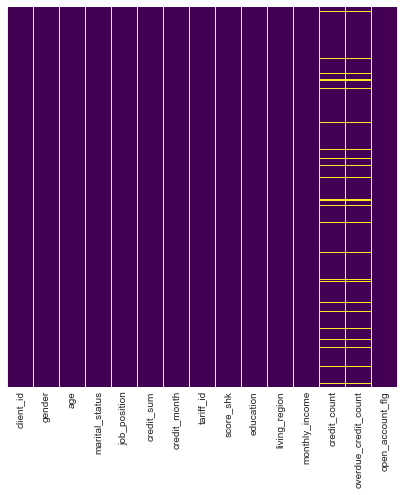

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')


In [18]:
# объеденим все категории с частотой менее 55 наблюдений в отдельную категорию OTHER
df.at[df['job_position'] == 'PNV', 'job_position'] = 'OTHER'
df.at[df['job_position'] == 'PNS', 'job_position'] = 'OTHER'
df.at[df['job_position'] == 'HSK', 'job_position'] = 'OTHER'
df.at[df['job_position'] == 'INV', 'job_position'] = 'OTHER'
df.at[df['job_position'] == 'ONB', 'job_position'] = 'OTHER'

In [19]:
# выводим частоты категорий для переменной tariff_id
print(df['tariff_id'].value_counts(dropna=False))

1.10    69355
1.60    39117
1.32    15537
1.40    10970
1.50     7497
1.90     5538
1.43     3930
1.30     3339
1.16     3232
1.00     2245
1.44     2228
1.19     2102
1.20     1306
1.70     1007
1.17      717
1.21      579
1.94      414
1.22      376
1.23      370
1.91      317
1.24      303
1.41      132
1.25       56
1.18       36
1.26       11
1.28       10
1.52        7
1.27        6
1.48        5
1.56        2
1.96        1
1.29        1
Name: tariff_id, dtype: int64


In [21]:
# все категории с частотой менее 55 наблюдений объеденим в отдельную категорию 1.99

df.loc[df['tariff_id'].value_counts()[df['tariff_id']].values < 55, 'tariff_id'] = 1.99
print(df['tariff_id'].value_counts(dropna=False))

# на основе категориальной переменной tariff_id создаем
# количественную переменную tariff
df['tariff'] = df['tariff_id'].astype('float')
# заменим точки на символы подчеркивания
df['tariff_id'] = df['tariff_id'].astype('str').str.replace('.', '_')
df

1_1     69355
1_6     39117
1_32    15537
1_4     10970
1_5      7497
1_9      5538
1_43     3930
1_3      3339
1_16     3232
1_0      2245
1_44     2228
1_19     2102
1_2      1306
1_7      1007
1_17      717
1_21      579
1_94      414
1_22      376
1_23      370
1_91      317
1_24      303
1_41      132
1_99       79
1_25       56
Name: tariff_id, dtype: int64


<ipython-input-21-07ee528b11ae>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['tariff_id'] = df['tariff_id'].astype('str').str.replace('.', '_')


,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,tariff
0,1,M,48,MAR,UMN,59998.00,10,1_6,0.770249,GRD,КРАСНОДАРСКИЙ,30000.0,1.0,1.0,0,16.0
1,2,F,28,MAR,UMN,10889.00,6,1_1,0.248514,GRD,МОСКВА,43000.0,2.0,0.0,0,11.0
2,3,M,32,MAR,SPC,10728.00,12,1_1,0.459589,SCH,САРАТОВСКАЯ,23000.0,5.0,0.0,0,11.0
3,4,F,27,DIV,SPC,12009.09,12,1_1,0.362536,GRD,ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0,11.0
4,5,M,45,MAR,SPC,16908.89,10,1_1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,25000.0,1.0,0.0,0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,170742,F,27,UNM,SPC,64867.00,12,1_1,0.535257,GRD,ТАТАРСТАН,40000.0,6.0,0.0,0,11.0
170742,170743,F,24,MAR,SPC,17640.00,6,1_6,0.573287,SCH,САНКТ-ПЕТЕРБУРГ,30000.0,1.0,0.0,0,16.0
170743,170744,F,31,UNM,SPC,27556.47,10,1_32,0.416098,GRD,ПРИМОРСКИЙ,40000.0,1.0,0.0,0,132.0
170744,170745,F,53,DIV,PNA,6189.00,12,1_1,0.482595,SCH,ПЕНЗЕНСКАЯ,31000.0,2.0,0.0,0,11.0


#### Проводим фильтрацию по регионам с частотой наблюдений меньше 50 и объединяем их в отдельную категорию other
Для этого определим относительную частоту как 



In [22]:
# относительная частота
v = 50 * 100 / df.shape[0]
v

0.02928326285828072

In [23]:
# создаем серию, у которой значениями будут частоты категорий переменной living_region
region_series = df['living_region'].value_counts()
# создаем булеву маску, если частота категории меньше 0.029,
# будет возвращено значение TRUE, в противном случае
# будет возвращено значение FALSE
mask = (region_series/region_series.sum() * 100).lt(v)
# с помощью функции np.where мы все категории, по которым возвращено
# значение TRUE, заменим на категорию OTHER, в противном случае
# оставим категории неизменными

df['living_region'] = np.where(df['living_region'].isin(region_series[mask].index),
                              'OTHER', df['living_region'])

# выводим частоты для последних 10 категорий переменной living_region
print(df['living_region'].value_counts(dropna=False).tail(10))

КАМЧАТСКИЙ               412
СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ    379
КАЛМЫКИЯ                 305
ЕВРЕЙСКАЯ                203
nan                      192
НЕНЕЦКИЙ                 172
МАГАДАНСКАЯ              159
OTHER                    100
ДАГЕСТАН                  69
АЛТАЙ                     54
Name: living_region, dtype: int64


In [25]:
data = df.copy()
data

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,tariff
0,1,M,48,MAR,UMN,59998.00,10,1_6,0.770249,GRD,КРАСНОДАРСКИЙ,30000.0,1.0,1.0,0,16.0
1,2,F,28,MAR,UMN,10889.00,6,1_1,0.248514,GRD,МОСКВА,43000.0,2.0,0.0,0,11.0
2,3,M,32,MAR,SPC,10728.00,12,1_1,0.459589,SCH,САРАТОВСКАЯ,23000.0,5.0,0.0,0,11.0
3,4,F,27,DIV,SPC,12009.09,12,1_1,0.362536,GRD,ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0,11.0
4,5,M,45,MAR,SPC,16908.89,10,1_1,0.421385,SCH,ЧЕЛЯБИНСКАЯ,25000.0,1.0,0.0,0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,170742,F,27,UNM,SPC,64867.00,12,1_1,0.535257,GRD,ТАТАРСТАН,40000.0,6.0,0.0,0,11.0
170742,170743,F,24,MAR,SPC,17640.00,6,1_6,0.573287,SCH,САНКТ-ПЕТЕРБУРГ,30000.0,1.0,0.0,0,16.0
170743,170744,F,31,UNM,SPC,27556.47,10,1_32,0.416098,GRD,ПРИМОРСКИЙ,40000.0,1.0,0.0,0,132.0
170744,170745,F,53,DIV,PNA,6189.00,12,1_1,0.482595,SCH,ПЕНЗЕНСКАЯ,31000.0,2.0,0.0,0,11.0


Text(0, 0.5, 'Записей')

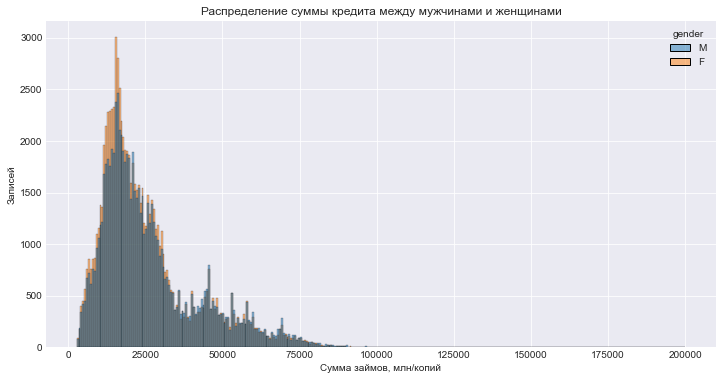

In [36]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.histplot(data=data, x='credit_sum', hue='gender', alpha=0.5)
ax.set_title('Распределение суммы кредита между мужчинами и женщинами')
ax.set_xlabel('Сумма займов, млн/копий')
ax.set_ylabel('Записей')

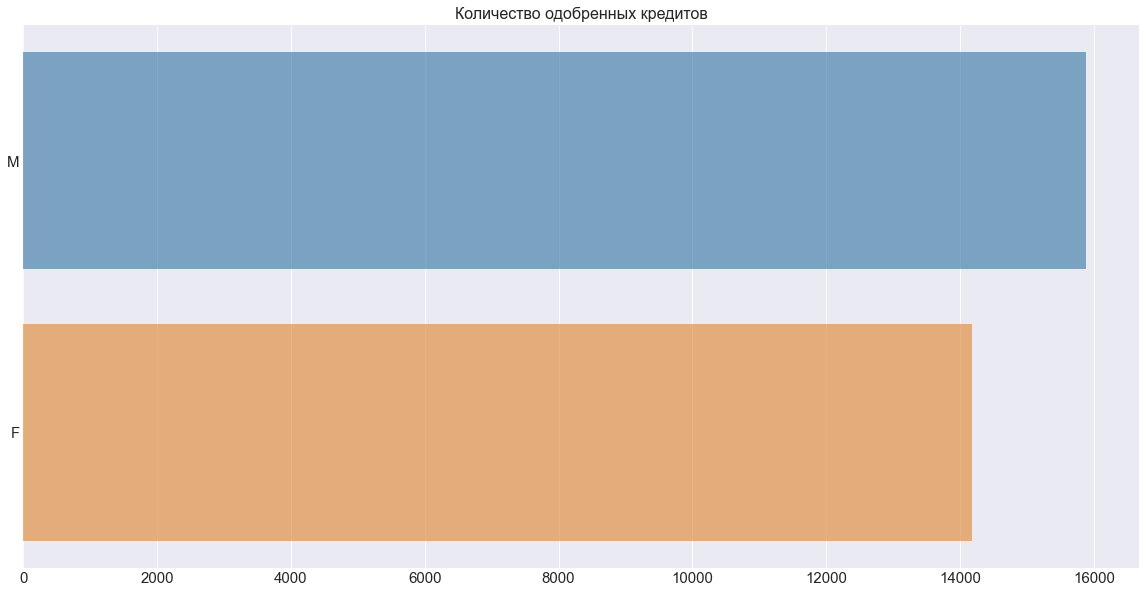

In [38]:
# количество одобренных кредитов
norm_credit = data.query('open_account_flg == 1')['gender'].value_counts()

plt.figure(figsize=(20,10))
plt.title("Количество одобренных кредитов", fontsize=16)
plt.tick_params(labelsize=15)

sns.barplot(y=norm_credit.index, x=norm_credit.values, alpha=0.6)
plt.show()

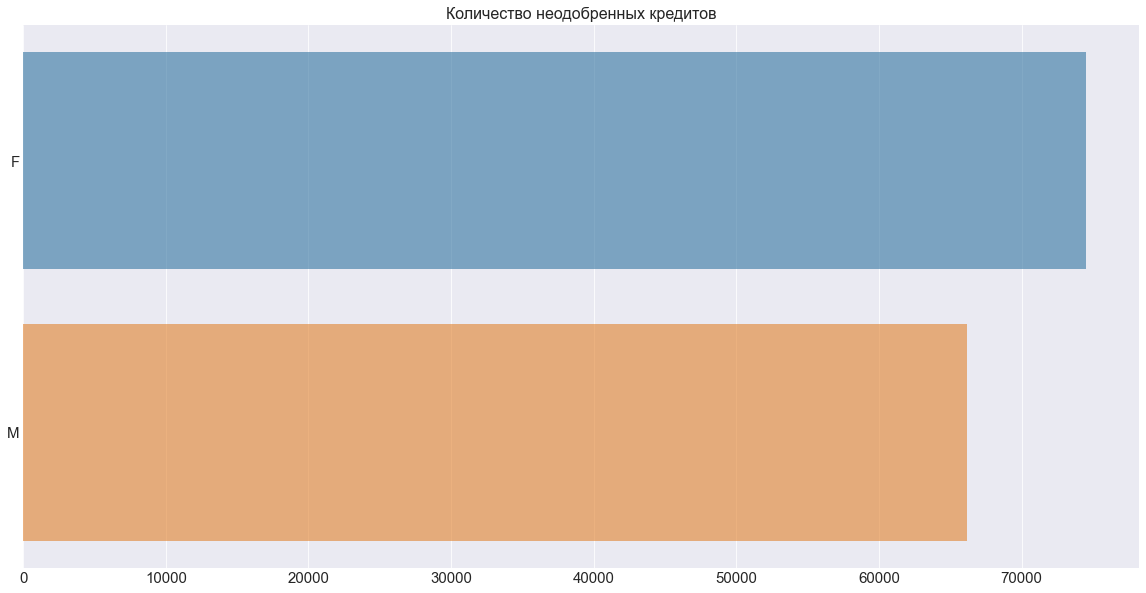

In [56]:
# количество неодобренных кредитов
norm_credit = data.query('open_account_flg == 0')['gender'].value_counts()

plt.figure(figsize=(20,10))
plt.title("Количество неодобренных кредитов", fontsize=16)
plt.tick_params(labelsize=15)

sns.barplot(y=norm_credit.index, x=norm_credit.values, alpha=0.6)
plt.show()

Text(0, 0.5, 'Записей')

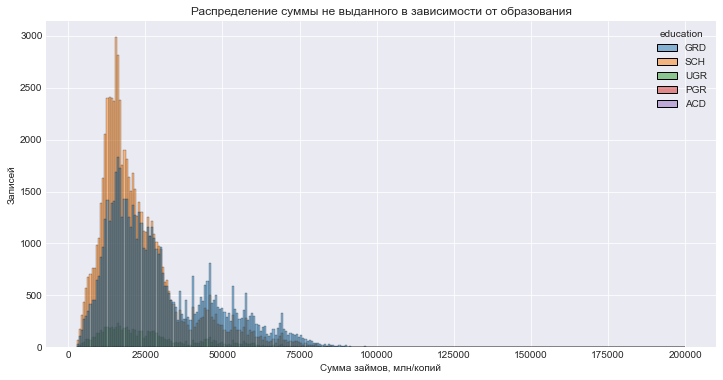

In [54]:
# Распределение суммы невыданных кредитов в зависимости от образования
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.histplot(data=data.query('open_account_flg == 0')
                  , x='credit_sum', hue='education', alpha=0.5)
ax.set_title('Распределение суммы не выданного в зависимости от образования')
ax.set_xlabel('Сумма займов, млн/копий')
ax.set_ylabel('Записей')

Text(0, 0.5, 'Записей')

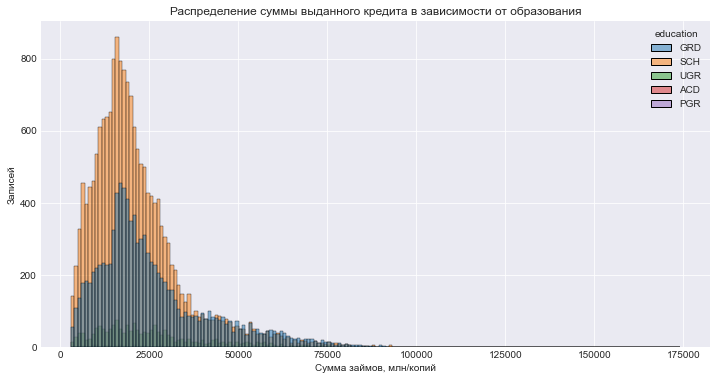

In [55]:
# Распределение суммы выданных кредитов в зависимости от образования
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.histplot(data=data.query('open_account_flg == 1')
                  , x='credit_sum', hue='education', alpha=0.5)
ax.set_title('Распределение суммы выданного кредита в зависимости от образования')
ax.set_xlabel('Сумма займов, млн/копий')
ax.set_ylabel('Записей')

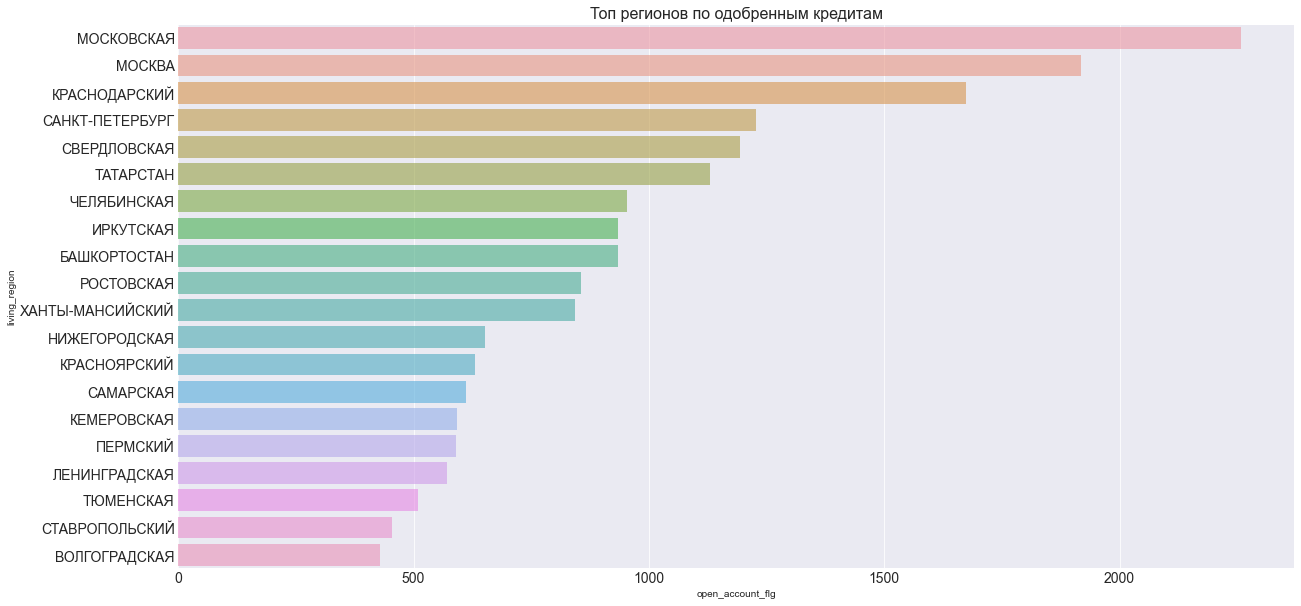

In [52]:
# Топ регионов по выданным кредитам
data_reg= data.query('open_account_flg == 1') \
            .groupby('living_region') \
            .count() \
            .sort_values(by='open_account_flg', ascending=False) \
            .reset_index() \
            

data_reg11 = data_reg.set_index('living_region').head(20)
plt.figure(figsize=(20,10))
plt.title("Топ регионов по одобренным кредитам", fontsize=16)
plt.tick_params(labelsize=14)

sns.barplot(y=data_reg11.index, x=data_reg11.open_account_flg, alpha=0.6)
plt.show();

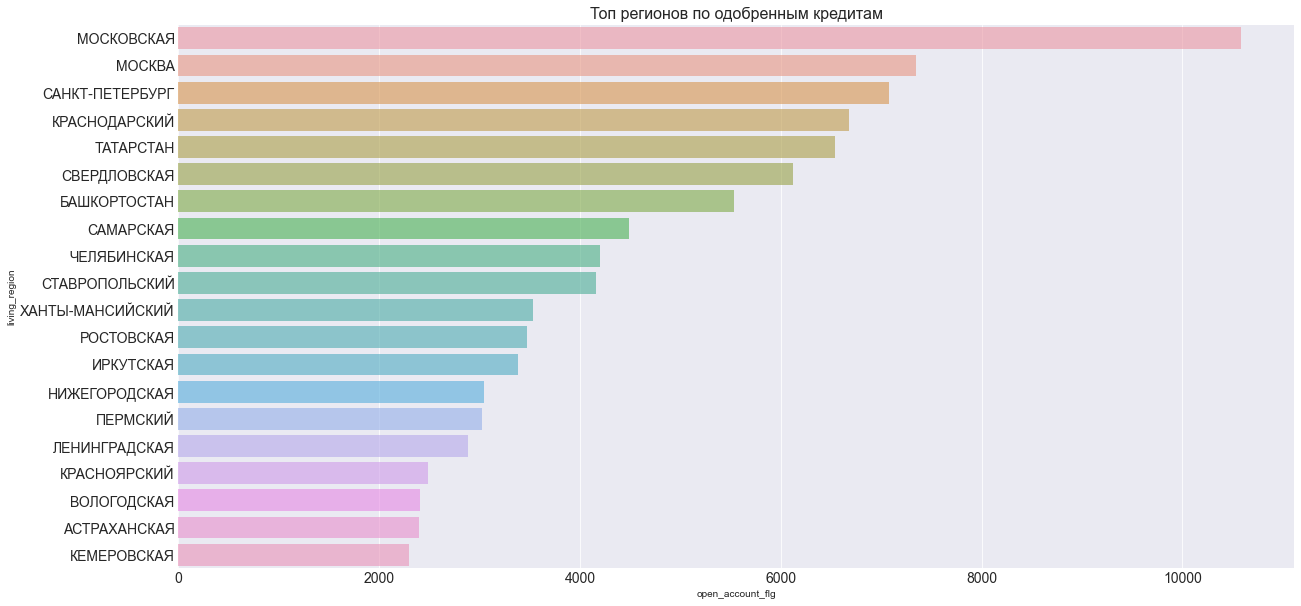

In [53]:
# Топ регионов по невыданным кредитам
data_reg= data.query('open_account_flg == 0') \
            .groupby('living_region') \
            .count() \
            .sort_values(by='open_account_flg', ascending=False) \
            .reset_index() \
            

data_reg11 = data_reg.set_index('living_region').head(20)
plt.figure(figsize=(20,10))
plt.title("Топ регионов по одобренным кредитам", fontsize=16)
plt.tick_params(labelsize=14)

sns.barplot(y=data_reg11.index, x=data_reg11.open_account_flg, alpha=0.6)
plt.show();

No handles with labels found to put in legend.


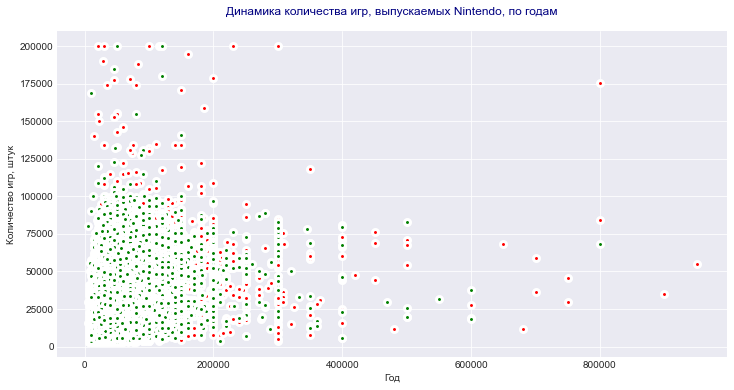

In [62]:
#data_m = data.query('gender == "M"')

fig, ax = plt.subplots(figsize=(12,6))

#sns.lineplot(data=data_m, x='monthly_income', y='credit_sum', color='red', linewidth=3)

sns.scatterplot(data=data.query('gender == "M"'), x='monthly_income', y='credit_sum', color='red', linewidth=3)
sns.scatterplot(data=data.query('gender == "F"'), x='monthly_income', y='credit_sum', color='green', linewidth=3)
ax.set_title('Зависимость суммы кредита, от ', pad=16, color='navy')  
ax.set_xlabel('Год')
ax.set_ylabel('Количество игр, штук')
ax.legend()

#ax.axvspan(xmin=2004, xmax=2007, color='green', alpha=0.4)

### Разбиение набора данных на обучающую и контрольную

In [68]:
# с помощью метода .sample из исходного датафрейма df случайно отбираем
# 70% наблюдений в обучающий датафрейм train
train = df.sample(frac=0.7,random_state=200)

# в исходном датафрейме df оставляем только те
# наблюдения, индексные метки которых отличаются
# от индекса наблюдений, попавших в обучающий датафрейм
# train, и записываем контрольный датафрейм test
test = df.drop(train.index)

### Импутация пропусков

In [69]:
# выводим информацию о количестве пропусков
# по каждой переменной в обучающей выборке
train.isnull().sum()

client_id                  0
gender                     0
age                        0
marital_status             0
job_position               0
credit_sum                 0
credit_month               0
tariff_id                  0
score_shk                  0
education                  0
living_region              0
monthly_income             1
credit_count            6477
overdue_credit_count    6477
open_account_flg           0
tariff                     0
dtype: int64

In [70]:
# выводим информацию о количестве пропусков по каждой переменной в контрольной выборке
test.isnull().sum()

client_id                  0
gender                     0
age                        0
marital_status             0
job_position               0
credit_sum                 0
credit_month               0
tariff_id                  0
score_shk                  0
education                  0
living_region              0
monthly_income             0
credit_count            2753
overdue_credit_count    2753
open_account_flg           0
tariff                     0
dtype: int64

In [71]:
# заполняем пропуски в переменных credit_count, overdue_credit_count -1
for i in ['credit_count', 'overdue_credit_count']:
    train[i].fillna(-1, inplace=True)
    
for i in ['credit_count', 'overdue_credit_count']:
    test[i].fillna(-1, inplace=True)

In [72]:
# monthly_income заменим медианным значением
for i in ['monthly_income']:
    train[i].fillna(train[i].median(), inplace=True)
    
for i in ['monthly_income']:
    test[i].fillna(train[i].median(), inplace=True)

### Конструирование новых признаков

In [73]:
# создаем переменную paym, которая является отношением выданной суммы кредита
# (credit_sum) к сроку кредита (credit_month), то есть ежемесячной суммой кредита
train['paym'] = train['credit_sum'] / train['credit_month']
test['paym'] = test['credit_sum'] / test['credit_month']

In [74]:
# создаем переменную pti, которая является отношением ежемесячной суммы кредита
# (paym) к ежемесячному заработку (monthly_income)
train['pti'] = train['paym'] / train['monthly_income']
test['pti'] = test['paym'] / test['monthly_income']

# заменяем бесконечные значения на 1
train['pti'].replace([np.inf, -np.inf], 1, inplace=True)
test['pti'].replace([np.inf, -np.inf], 1, inplace=True)

In [75]:
# создаем новые переменные, возведя некоторые количественные переменные в квадрат
train['tariff_sq'] = train['tariff']**2
test['tariff_sq'] = test['tariff']**2

train['age_sq'] = train['age']**2
test['age_sq'] = test['age']**2

train['credit_sum_sq'] = train['credit_sum']**2
test['credit_sum_sq'] = test['credit_sum']**2

train['score_sq'] = train['score_shk']**2
test['score_sq'] = test['score_shk']**2

train['income_sq'] = train['monthly_income']**2
test['income_sq'] = test['monthly_income']**2

train['credit_month_sq'] = train['credit_month']**2
test['credit_month_sq'] = test['credit_month']**2

train['credit_count_sq'] = train['credit_count']**2
test['credit_count_sq'] = test['credit_count']**2

### Дамми- кодирование количественных признаков

In [76]:
# печатаем названия столбцов до и после дамми-кодирования
print("Исходные переменные:\n", list(train.columns), "\n")
train_dummies = pd.get_dummies(train)
print("Переменные после get_dummies:\n", list(train_dummies.columns))

print("Исходные переменные:\n", list(test.columns), "\n")
test_dummies = pd.get_dummies(test)
print("Переменные после get_dummies:\n", list(test_dummies.columns))

Исходные переменные:
 ['client_id', 'gender', 'age', 'marital_status', 'job_position', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'education', 'living_region', 'monthly_income', 'credit_count', 'overdue_credit_count', 'open_account_flg', 'tariff', 'paym', 'pti', 'tariff_sq', 'age_sq', 'credit_sum_sq', 'score_sq', 'income_sq', 'credit_month_sq', 'credit_count_sq'] 

Переменные после get_dummies:
 ['client_id', 'age', 'credit_sum', 'credit_month', 'score_shk', 'monthly_income', 'credit_count', 'overdue_credit_count', 'tariff', 'paym', 'pti', 'tariff_sq', 'age_sq', 'credit_sum_sq', 'score_sq', 'income_sq', 'credit_month_sq', 'credit_count_sq', 'gender_F', 'gender_M', 'marital_status_CIV', 'marital_status_DIV', 'marital_status_MAR', 'marital_status_UNM', 'marital_status_WID', 'job_position_ATP', 'job_position_BIS', 'job_position_BIU', 'job_position_DIR', 'job_position_INP', 'job_position_NOR', 'job_position_OTHER', 'job_position_PNA', 'job_position_PNI', 'job_position_SPC', 'j

In [77]:
# увеличиваем количество выводимых столбцов
pd.set_option('display.max_columns', 150)
train_dummies.head()

,client_id,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,tariff,paym,pti,tariff_sq,age_sq,credit_sum_sq,score_sq,income_sq,credit_month_sq,credit_count_sq,gender_F,gender_M,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID,job_position_ATP,job_position_BIS,job_position_BIU,job_position_DIR,job_position_INP,job_position_NOR,job_position_OTHER,job_position_PNA,job_position_PNI,job_position_SPC,job_position_UMN,job_position_WOI,job_position_WRK,job_position_WRP,tariff_id_1_0,tariff_id_1_1,tariff_id_1_16,tariff_id_1_17,tariff_id_1_19,tariff_id_1_2,tariff_id_1_21,tariff_id_1_22,tariff_id_1_23,tariff_id_1_24,tariff_id_1_25,tariff_id_1_3,tariff_id_1_32,tariff_id_1_4,tariff_id_1_41,tariff_id_1_43,tariff_id_1_44,tariff_id_1_5,tariff_id_1_6,tariff_id_1_7,tariff_id_1_9,tariff_id_1_91,tariff_id_1_94,tariff_id_1_99,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,living_region_OTHER,living_region_nan,living_region_АДЫГЕЯ,living_region_АЛТАЙ,living_region_АЛТАЙСКИЙ,living_region_АМУРСКАЯ,living_region_АРХАНГЕЛЬСКАЯ,...,living_region_БЕЛГОРОДСКАЯ,living_region_БРЯНСКАЯ,living_region_БУРЯТИЯ,living_region_ВЛАДИМИРСКАЯ,living_region_ВОЛГОГРАДСКАЯ,living_region_ВОЛОГОДСКАЯ,living_region_ВОРОНЕЖСКАЯ,living_region_ДАГЕСТАН,living_region_ЕВРЕЙСКАЯ,living_region_ЗАБАЙКАЛЬСКИЙ,living_region_ИВАНОВСКАЯ,living_region_ИРКУТСКАЯ,living_region_КАБАРДИНО-БАЛКАРСКАЯ,living_region_КАЛИНИНГРАДСКАЯ,living_region_КАЛМЫКИЯ,living_region_КАЛУЖСКАЯ,living_region_КАМЧАТСКИЙ,living_region_КАРАЧАЕВО-ЧЕРКЕССКАЯ,living_region_КАРЕЛИЯ,living_region_КЕМЕРОВСКАЯ,living_region_КИРОВСКАЯ,living_region_КОМИ,living_region_КОСТРОМСКАЯ,living_region_КРАСНОДАРСКИЙ,living_region_КРАСНОЯРСКИЙ,living_region_КУРГАНСКАЯ,living_region_КУРСКАЯ,living_region_ЛЕНИНГРАДСКАЯ,living_region_ЛИПЕЦКАЯ,living_region_МАГАДАНСКАЯ,living_region_МАРИЙЭЛ,living_region_МОРДОВИЯ,living_region_МОСКВА,living_region_МОСКОВСКАЯ,living_region_МУРМАНСКАЯ,living_region_НЕНЕЦКИЙ,living_region_НИЖЕГОРОДСКАЯ,living_region_НОВГОРОДСКАЯ,living_region_НОВОСИБИРСКАЯ,living_region_ОМСКАЯ,living_region_ОРЕНБУРГСКАЯ,living_region_ОРЛОВСКАЯ,living_region_ПЕНЗЕНСКАЯ,living_region_ПЕРМСКИЙ,living_region_ПРИМОРСКИЙ,living_region_ПСКОВСКАЯ,living_region_РОСТОВСКАЯ,living_region_РЯЗАНСКАЯ,living_region_САМАРСКАЯ,living_region_САНКТ-ПЕТЕРБУРГ,living_region_САРАТОВСКАЯ,living_region_САХА/ЯКУТИЯ/,living_region_САХАЛИНСКАЯ,living_region_СВЕРДЛОВСКАЯ,living_region_СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ,living_region_СМОЛЕНСКАЯ,living_region_СТАВРОПОЛЬСКИЙ,living_region_ТАМБОВСКАЯ,living_region_ТАТАРСТАН,living_region_ТВЕРСКАЯ,living_region_ТОМСКАЯ,living_region_ТУЛЬСКАЯ,living_region_ТЫВА,living_region_ТЮМЕНСКАЯ,living_region_УДМУРТСКАЯ,living_region_УЛЬЯНОВСКАЯ,living_region_ХАБАРОВСКИЙ,living_region_ХАКАСИЯ,living_region_ХАНТЫ-МАНСИЙСКИЙ,living_region_ЧЕЛЯБИНСКАЯ,living_region_ЧУВАШСКАЯ,living_region_ЯМАЛО-НЕНЕЦКИЙ,living_region_ЯРОСЛАВСКАЯ,open_account_flg_0,open_account_flg_1
53397,53398,28,33579.0,10,0.431360,36000.0,2.0,0.0,14.0,3357.900000,0.093275,196.0,784,1.127549e+09,0.186071,1.296000e+09,100,4.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
143962,143963,38,23511.0,10,0.358472,45000.0,2.0,0.0,132.0,2351.100000,0.052247,17424.0,1444,5.527671e+08,0.128502,2.025000e+09,100,4.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
146922,146923,25,39990.0,24,0.613475,50000.0,6.0,0.0,15.0,1666.250000,0.033325,225.0,625,1.599200e+09,0.376352,2.500000e+09,576,36.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0

In [78]:
# создаем обучающий и контрольный массивы значений зависимой переменной
y_train = train_dummies.loc[:, 'open_account_flg_1']
y_test = test_dummies.loc[:, 'open_account_flg_1']

In [79]:
# создаем обучающий и контрольный массивы значений признаков
X_train = train_dummies.loc[:, 'age':'living_region_ЯРОСЛАВСКАЯ']
X_test = test_dummies.loc[:, 'age':'living_region_ЯРОСЛАВСКАЯ']

## Случайный лес

In [89]:
# импортируем класс RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
#Обучаем классификатор
clf_rndForest = RandomForestClassifier(random_state=42, n_estimators=151) # создадим модель градиентного бустинга с параметрами:
#random_state=42 зададим random_state для воспроизведения результатов
clf_rndForest = clf_rndForest.fit(X_train, y_train) # оценим параметры модели

# Получим прогноз
y_pred_rndForest = clf_rndForest.predict(X_test)  # прогноз отношения к классу 0 или 1
y_pred_rndForest_proba = clf_rndForest.predict_proba(X_test)[:, 1]  # прогнозные вероятности отношения к классу 0 и 1

### Метод градиентного Бустинга

In [87]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Обучаем классификатор
clf_gbst = GradientBoostingClassifier(random_state=42) # создадим модель градиентного бустинга с параметрами:
#random_state=42 зададим random_state для воспроизведения результатов
clf_gbst = clf_gbst.fit(X_train, y_train) # оценим параметры модели

# Получаем прогноз
y_pred_gbst = clf_gbst.predict(X_test)  # прогноз отношения к классу 0 или 1
y_pred_gbst_proba = clf_gbst.predict_proba(X_test)[:, 1]  # прогнозные вероятности отношения к классу 0 и 1

Коэффициент Джини для RandomForestClassifier(n_estimators=151, random_state=42) : 0.5
AUROC для RandomForestClassifier(n_estimators=151, random_state=42) : 0.75 

Коэффициент Джини для GradientBoostingClassifier(random_state=42) : 0.52
AUROC для GradientBoostingClassifier(random_state=42) : 0.76 



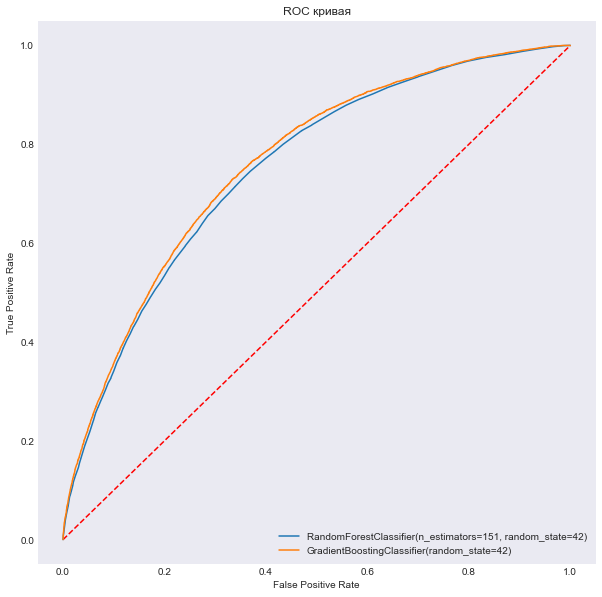

In [90]:
y_pred_probas_new = [y_pred_rndForest_proba,y_pred_gbst_proba] 

clfs = [clf_rndForest, clf_gbst]

fig, ax = plt.subplots(figsize =(10, 10)) # Создадим график
ax.grid()
ax.plot([0, 1], [0, 1],'r--') # отобразим на графике ROC-кривую для случайной модели

for i in range(len(y_pred_probas_new)): # цикл для каждого классификатора
    roc_auc = roc_auc_score(y_test, y_pred_probas_new[i]) # Расчет AUROC. На вход подаются наблюдаемые значения тестовой выборки и прогнозные
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas_new[i]) # Построение ROC- кривой

    plt.plot(fpr, tpr, label= clfs[i]) #отобразим на графике ROC-кривую и значение AUROC
    print('Коэффициент Джини для', clfs[i],':', round(2 * roc_auc - 1,2)) # посчитаем и выведем значение коэффициента Джини для каждого классификатора
    print('AUROC для', clfs[i],':', round(roc_auc,2),'\n') # посчитаем и выведем значение коэффициента Джини для каждого классификатора
   
    
plt.xlabel('False Positive Rate') # название оси х
plt.ylabel('True Positive Rate') # название оси y
plt.title('ROC кривая')# название графика
plt.legend(loc="lower right") # расположение легенды
plt.savefig('Log_ROC') # сохранить график
plt.show(); # отобразитьграфик

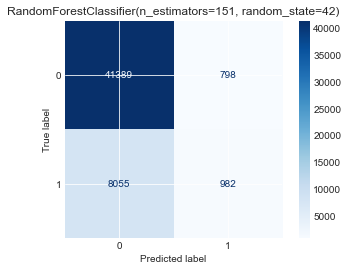

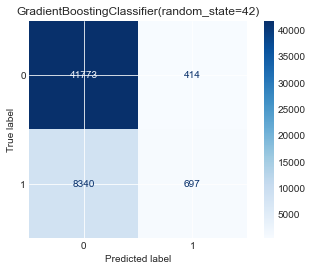

In [91]:
clfs = [clf_rndForest, clf_gbst]

for clf in clfs: # цикл для каждого классификатора
    matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues) # нарисуем матрицу ошибок
    plt.title(clf) # зададим название графика
    plt.show(matrix) # отобразим график
    print('\n')# перенос строки

## Метрики качества

In [93]:
# лист прогноза отношения к классу 0 или 1 для каждого классификатора:
y_preds = [y_pred_rndForest, y_pred_gbst] 

for i in range(len(y_preds)): #цикл для каждого классификатора
    print('\nМетрики качества модели для:',clfs[i], '\n')
    print(classification_report(y_test, y_preds[i]))  # выведем рассчитанные метрики качества


Метрики качества модели для: RandomForestClassifier(n_estimators=151, random_state=42) 

              precision    recall  f1-score   support

           0       0.84      0.98      0.90     42187
           1       0.55      0.11      0.18      9037

    accuracy                           0.83     51224
   macro avg       0.69      0.54      0.54     51224
weighted avg       0.79      0.83      0.78     51224


Метрики качества модели для: GradientBoostingClassifier(random_state=42) 

              precision    recall  f1-score   support

           0       0.83      0.99      0.91     42187
           1       0.63      0.08      0.14      9037

    accuracy                           0.83     51224
   macro avg       0.73      0.53      0.52     51224
weighted avg       0.80      0.83      0.77     51224



# Catboost

In [94]:
# импортируем классы CatBoostClassifier, Pool, cv
from catboost import CatBoostClassifier, Pool, cv

In [95]:
# подготавливаем массив меток для catboost
y_train_catboost = train['open_account_flg'].astype('int')
y_test_catboost = test['open_account_flg'].astype('int')
# подготавливаем массив признаков для catboost
X_train_catboost = train.drop('open_account_flg', axis=1)
X_test_catboost = test.drop('open_account_flg', axis=1)

In [96]:
# записываем список индексов категориальных предикторов
cat_features_idx = np.where(X_train_catboost.dtypes == 'object')[0].tolist()
# выводим этот список
cat_features_idx

[1, 3, 4, 7, 9, 10]

In [98]:
# задаем настройки и параметры
params = {
'loss_function': 'Logloss',
'eval_metric': 'AUC',
'custom_metric': 'F1',
'random_seed': 42,
'logging_level': 'Silent',
'use_best_model': False
}

# создаем обучающий и контрольный пулы
train_pool = Pool(X_train_catboost, y_train_catboost, cat_features=cat_features_idx)
validate_pool = Pool(X_test_catboost, y_test_catboost, cat_features=cat_features_idx)

# создаем экземпляр класса CatBoostClassifier с настройками и параметрами
model = CatBoostClassifier(**params)
# обучаем модель на обучающем пуле, с помощью контрольного пула оптимизируем AUC
# и печатаем графики обучения и валидации
model.fit(train_pool, eval_set=validate_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [99]:
# печатаем значение AUC для контрольной выборки
print('AUC модели на контрольной выборке: {:.3}'.format(
roc_auc_score(y_test_catboost, model.predict_proba(X_test_catboost)[:, 1])))

AUC модели на контрольной выборке: 0.77
